In [1]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from models import RVAEModel, ClassModel, CRGANModel
from data_utils import DataFactory
from fastdtw import fastdtw
import fancyimpute
tf.enable_eager_execution()
%matplotlib inline

/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/malzantot/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
import impute_utils

In [3]:
CHECKPOINT_DIR = './save/har_physgan/07_28_17_55'
AUX_CHECKPOINT_DIR = './save/har_lstm/07_22_21_13'
ecg_train, ecg_test, metadata = DataFactory.create_dataset('har')

model = RVAEModel(enc_rnn_units=128,z_dim=16,dec_rnn_units=128,num_feats=metadata.num_feats,num_labels=metadata.num_labels)
#model = CRGANModel(num_feats=1,num_labels=2,z_dim=8,num_units=128)

aux_model = ClassModel(num_feats=6,num_labels=6)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([1226, 1073,  986, 1286, 1374, 1407]))
(7352, 32, 6)
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([496, 471, 420, 491, 532, 537]))
(2947, 32, 6)


W0813 23:07:22.514594 140469402548032 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:103: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.



In [4]:
har_train, har_test, metadata = DataFactory.create_dataset('har')
train_x, train_y = next(iter(har_train.shuffle(1000).batch(500)))
train_x = train_x.numpy()
train_y = train_y.numpy()

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([1226, 1073,  986, 1286, 1374, 1407]))
(7352, 32, 6)
(array([0, 1, 2, 3, 4, 5], dtype=int32), array([496, 471, 420, 491, 532, 537]))
(2947, 32, 6)


In [5]:
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

aux_checkpoint = tf.train.Checkpoint(model=aux_model)
aux_checkpoint.restore(tf.train.latest_checkpoint(AUX_CHECKPOINT_DIR))

### Prepare data

In [6]:
data_file = 'test_har_segment.pkl' # Set this to None, to generate a new test set

mask_type = 'segment'
mask_prob = 0.25
test_size=500

if data_file is None:
    test_x, test_y, test_masks, test_masked = impute_utils.get_testset(ecg_test,
                                                      mask_type=mask_type,
                                                      mask_prob=mask_prob,
                                                      test_size=test_size)
else:
    test_x, test_y, test_masks, test_masked = impute_utils.get_data_from_pickle(data_file)
print(test_masks.shape)

(500, 32, 6)


In [7]:
accuracy_complete = impute_utils.evaluate_accuracy(aux_model, test_x, test_y)
print("Accuracy of complete data = {:.2f}".format(accuracy_complete))
accuracy_incomplete = impute_utils.evaluate_accuracy(aux_model, test_masked, test_y)
print('Accuracy of incomplete data = {:.2f}'.format(accuracy_incomplete))

W0813 23:07:28.280125 140469402548032 deprecation.py:323] From /home/malzantot/Nesl/bio_gan/impute_utils.py:98: arg_max (from tensorflow.python.ops.gen_math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.math.argmax` instead


Accuracy of complete data = 0.87
Accuracy of incomplete data = 0.20


### Imputation code

In [8]:
def impute_mice(train_x, train_y, test_x, test_y, test_masks):
    x_incomplete = np.r_[ test_x, train_x]
    y_incomplete = np.r_[ test_y, train_y]
    x_mice = []
    for k in range(train_x.shape[2]):
        x_mice.append(fancyimpute.MICE(n_imputations=100, n_pmm_neighbors=20, verbose=False).complete(x_incomplete[:,:,k])[:,:,np.newaxis])
    x_mice = np.concatenate(x_mice, axis=2)
    return x_mice[:test_x.shape[0],:,:]

In [9]:
def impute_knn(train_x, train_y, test_x, test_y, test_masks):
    x_incomplete = np.r_[ test_x, train_x]
    y_incomplete = np.r_[ test_y, train_y]
    x_knn = []
    for k in range(train_x.shape[2]):
        x_knn.append(fancyimpute.KNN(k=10,verbose=True).complete(x_incomplete[:,:,k])[:,:,np.newaxis])
    x_knn = np.concatenate(x_knn, axis=2)
    return x_knn[:test_x.shape[0],:,:]

In [10]:
def impute_physgan(train_x, train_y, test_x, test_y, test_masks):
    impute_outputs = []
    for i, (x_mask, x_in, x_label) in enumerate(zip(test_masks, test_x, test_y)):
        x_in_tf = tf.convert_to_tensor([np.nan_to_num(x_in)])
        x_label = x_label.reshape((-1,))
        x_mask = np.nan_to_num(x_mask)
        impute_result = model.impute(x_in_tf, x_label, x_mask).numpy()
        impute_outputs.append(impute_result[0])
    return np.array(impute_outputs)

In [11]:
impute_methods = {'mice': impute_mice, 'knn':impute_knn, 'physgan':impute_physgan}

## Actual experiments

In [12]:
methods = [ 'knn', 'physgan']
result = {}
for m in methods:
    print('Trying {}'.format(m))
    m_complete = impute_methods[m](train_x, train_y, test_masked, test_y, test_masks)
    result[m] = m_complete

Trying knn
Imputing row 1/1000 with 8 missing, elapsed time: 0.150
Imputing row 101/1000 with 8 missing, elapsed time: 0.162
Imputing row 201/1000 with 8 missing, elapsed time: 0.173
Imputing row 301/1000 with 8 missing, elapsed time: 0.184
Imputing row 401/1000 with 8 missing, elapsed time: 0.195
Imputing row 501/1000 with 0 missing, elapsed time: 0.207
Imputing row 601/1000 with 0 missing, elapsed time: 0.207
Imputing row 701/1000 with 0 missing, elapsed time: 0.207
Imputing row 801/1000 with 0 missing, elapsed time: 0.208
Imputing row 901/1000 with 0 missing, elapsed time: 0.208
Imputing row 1/1000 with 8 missing, elapsed time: 0.143
Imputing row 101/1000 with 8 missing, elapsed time: 0.155
Imputing row 201/1000 with 8 missing, elapsed time: 0.166
Imputing row 301/1000 with 8 missing, elapsed time: 0.177
Imputing row 401/1000 with 8 missing, elapsed time: 0.188
Imputing row 501/1000 with 0 missing, elapsed time: 0.199
Imputing row 601/1000 with 0 missing, elapsed time: 0.199
Imputin

W0813 23:07:29.615424 140469402548032 deprecation_wrapper.py:119] From /home/malzantot/Nesl/bio_gan/models.py:112: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Imputing row 201/1000 with 8 missing, elapsed time: 0.168
Imputing row 301/1000 with 8 missing, elapsed time: 0.179
Imputing row 401/1000 with 8 missing, elapsed time: 0.190
Imputing row 501/1000 with 0 missing, elapsed time: 0.201
Imputing row 601/1000 with 0 missing, elapsed time: 0.201
Imputing row 701/1000 with 0 missing, elapsed time: 0.202
Imputing row 801/1000 with 0 missing, elapsed time: 0.202
Imputing row 901/1000 with 0 missing, elapsed time: 0.202
Trying physgan


### Evaluation

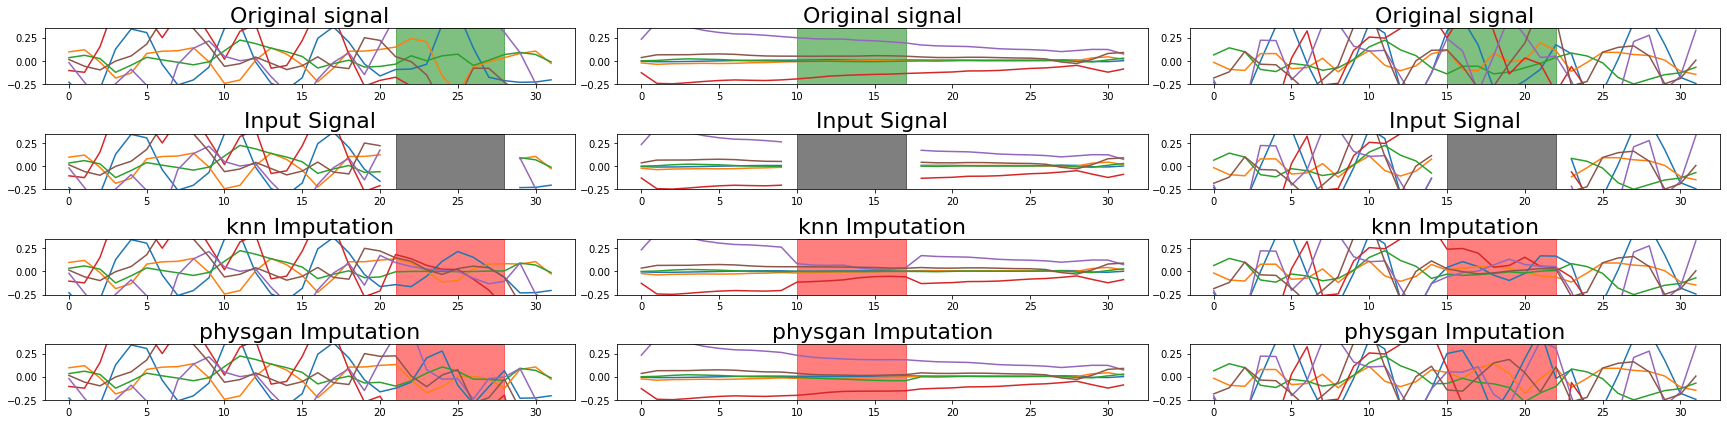

In [13]:
results_fig = impute_utils.plot_results(test_masked, test_x, test_masks, result, mask_type)
None

### Compute metrics

In [14]:
for i, m in enumerate(result.keys()):
    mae_score = impute_utils.evaluate_mae(test_x, result[m], test_masks)
    sem_score = impute_utils.evaluate_semantic(aux_model, test_x, test_y, test_masked, result[m])
    
    print('{} ::  MAE = {:.3f}  ::   Semantic = {:.3f}'.format(m, mae_score, sem_score))

knn ::  MAE = 0.077  ::   Semantic = 0.961
physgan ::  MAE = 0.114  ::   Semantic = 1.006
